## 테스트 데이터셋 로드

In [1]:
!pip install opencv-python

In [11]:
import os
import urllib.request
import tarfile
import pickle
import numpy as np
from common.functions import softmax  

def download_cifar100(save_path='cifar-100-python'):
    if os.path.exists(save_path):
        print("CIFAR-100 이미 존재")
        return

    url = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    filename = 'cifar-100-python.tar.gz'
    print("CIFAR-100 다운로드 중...")
    urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
    os.remove(filename)
    print("다운로드 완료")

def load_batch(filepath):
    with open(filepath, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    data = data_dict[b'data']
    fine_labels = np.array(data_dict[b'fine_labels'])
    coarse_labels = np.array(data_dict[b'coarse_labels'])
    data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    return data, fine_labels, coarse_labels

def load_cifar100_full(data_dir='./cifar-100-python', valid_ratio=0.1):
    # 1. Load train and test batch
    x_train_all, y_train_fine_all, y_train_coarse_all = load_batch(os.path.join(data_dir, 'train'))
    x_test, y_test_fine, y_test_coarse = load_batch(os.path.join(data_dir, 'test'))

    # 2. Split train → train + validation
    num_total = x_train_all.shape[0]
    num_valid = int(num_total * valid_ratio)

    x_valid = x_train_all[:num_valid]
    t_valid_fine = y_train_fine_all[:num_valid]
    t_valid_coarse = y_train_coarse_all[:num_valid]

    x_train = x_train_all[num_valid:]
    t_train_fine = y_train_fine_all[num_valid:]
    t_train_coarse = y_train_coarse_all[num_valid:]

    # 3. Return all
    return (x_train, x_valid, x_test,
            t_train_coarse, t_valid_coarse, y_test_coarse,
            t_train_fine, t_valid_fine, y_test_fine)

# CIFAR-100 다운로드
download_cifar100()

# 전체 데이터셋 로드
(x_train, x_valid, x_test,
 t_train_coarse, t_valid_coarse, t_test_coarse,
 t_train_fine, t_valid_fine, t_test_fine) = load_cifar100_full()

# 확인 출력
print("CIFAR-100 데이터셋 로드 완료:")
print(" - x_train:", x_train.shape)
print(" - x_valid:", x_valid.shape)
print(" - x_test :", x_test.shape)
print(" - t_train_fine :", t_train_fine.shape)
print(" - t_valid_fine :", t_valid_fine.shape)
print(" - t_test_fine  :", t_test_fine.shape)
print(" - t_train_coarse:", t_train_coarse.shape)
print(" - t_valid_coarse:", t_valid_coarse.shape)
print(" - t_test_coarse :", t_test_coarse.shape)

CIFAR-100 이미 존재
CIFAR-100 데이터셋 로드 완료:
 - x_train: (45000, 3, 32, 32)
 - x_valid: (5000, 3, 32, 32)
 - x_test : (10000, 3, 32, 32)
 - t_train_fine : (45000,)
 - t_valid_fine : (5000,)
 - t_test_fine  : (10000,)
 - t_train_coarse: (45000,)
 - t_valid_coarse: (5000,)
 - t_test_coarse : (10000,)


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from common.ResNet20 import ResNet20  # 사용자 정의 모델
from common.coarse_mapping import get_cifar100_fine_to_coarse_dict
import cv2

# --- Activation Map 시각화 ---
def visualize_activation(model, image, title="Activation Map", layer="conv1"):
    model.forward(image[np.newaxis], train_flg=False)

    if layer == "conv1":
        activ = model.conv1.forward(image[np.newaxis])[0]
    elif layer == "layer1":
        x = model.conv1.forward(image[np.newaxis])
        x = model.bn1.forward(x, train_flg=False)
        x = model.relu1.forward(x)
        activ = model.layer1[0].forward(x, train_flg=False)[0]
    elif layer == "layer2":
        x = model.conv1.forward(image[np.newaxis])
        x = model.bn1.forward(x, train_flg=False)
        x = model.relu1.forward(x)
        x = model.layer1[0].forward(x, train_flg=False)
        activ = model.layer2[0].forward(x, train_flg=False)[0]
    elif layer == "layer_final":
        _ = model.forward(image[np.newaxis], train_flg=False)
        activ = model.feature_map[0]  # 확실히 (C, H, W) 형태
    else:
        raise ValueError("Unsupported layer")

    num_channels = min(8, activ.shape[0])
    plt.figure(figsize=(2 * num_channels, 2))
    for i in range(num_channels):
        img = activ[i]
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        plt.subplot(1, num_channels, i + 1)
        plt.imshow(img, cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"{title} ({layer})")
    plt.tight_layout()
    plt.show()

# --- 2. t-SNE 시각화 ---
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from common.coarse_mapping import get_cifar100_fine_to_coarse_dict


def balanced_sample(labels, per_class=30, num_classes=100, random_state=42):
    np.random.seed(random_state)
    indices = []
    for i in range(num_classes):
        idx = np.where(labels == i)[0]
        if len(idx) < per_class:
            continue
        selected = np.random.choice(idx, size=per_class, replace=False)
        indices.extend(selected)
    return np.array(indices)

    
def plot_tsne_coarse(val_logits, pred_coarse, title="t-SNE (Coarse)", mapping_name=None, perplexity=30, save_path=None):
    """
    coarse label 기반 t-SNE 시각화 함수
    """
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    features_2d = tsne.fit_transform(val_logits)

    df = pd.DataFrame({
        "x": features_2d[:, 0],
        "y": features_2d[:, 1],
        "label": pred_coarse
    })

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x="x", y="y",
        hue="label",
        palette="tab20",
        data=df,
        s=30, alpha=0.7
    )

    if mapping_name:
        plt.title(f"{title} - {mapping_name}")
    else:
        plt.title(title)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, title="Coarse Class", fontsize="small")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()



def plot_tsne_fine(val_logits, fine_labels, title="Fine Class Embedding", perplexity=30, random_state=42, save_path=None):
    """
    100개 fine class 기준 t-SNE 시각화
    """
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    features_2d = tsne.fit_transform(val_logits)

    base_colors = sns.color_palette("tab20", 20)
    full_colors = base_colors * 5
    color_map = {i: full_colors[i] for i in range(100)}
    markers = ['o', 's', 'D', '^', 'X']
    marker_map = {i: markers[i // 20] for i in range(100)}

    df = pd.DataFrame({
        "x": features_2d[:, 0],
        "y": features_2d[:, 1],
        "label": fine_labels
    })

    plt.figure(figsize=(14, 12))
    for i in range(100):
        subset = df[df['label'] == i]
        plt.scatter(
            subset['x'], subset['y'],
            label=str(i),
            alpha=0.6,
            s=30,
            color=color_map[i],
            marker=marker_map[i]
        )

    plt.title(title, fontsize=15)
    plt.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6, ncol=2, title="Fine Label")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()



def plot_confusion_matrix_sns(y_true, y_pred, num_classes, title, class_labels=None, normalize=False):
    from sklearn.metrics import confusion_matrix
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes),
                          normalize='true' if normalize else None)

    annot = np.full_like(cm, "", dtype=object)
    for i in range(min(cm.shape[0], cm.shape[1])):
        val = cm[i, i]
        annot[i, i] = f"{val:.2f}" if normalize else f"{int(val)}"

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm,
                     annot=annot,
                     fmt="",  # 이미 문자열이므로 포맷 불필요
                     cmap='Blues',
                     annot_kws={'color': 'black'}) 
    

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)

    tick_freq = 5
    ticks = np.arange(0, num_classes, tick_freq)
    tick_labels = [str(i) for i in ticks]  # 숫자 문자열로 변환

    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=90, fontsize=6)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels, fontsize=6)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_fine_sns(y_true, y_pred, num_classes, title, class_labels=None, normalize=False):
    from sklearn.metrics import confusion_matrix
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes),
                          normalize='true' if normalize else None)

    annot = np.full_like(cm, "", dtype=object)
    for i in range(min(cm.shape[0], cm.shape[1])):
        val = cm[i, i]
        annot[i, i] = f"{val:.2f}" if normalize else f"{int(val)}"

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm,
                     annot=False,
                     fmt="",  # 이미 문자열이므로 포맷 불필요
                     cmap='Blues',
                     annot_kws={'color': 'black'}) 
    

    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)

    tick_freq = 5
    ticks = np.arange(0, num_classes, tick_freq)
    tick_labels = [str(i) for i in ticks]  # 숫자 문자열로 변환

    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=90, fontsize=6)
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels, fontsize=6)

    plt.tight_layout()
    plt.show()
    
# --- 3. Grad-CAM ---
def compute_gradcam(model, image, label_index):
    model.forward(image[np.newaxis], train_flg=True)
    y = model.forward(image[np.newaxis], train_flg=True)

    score = y[0, label_index]
    dout = np.zeros_like(y)
    dout[0, label_index] = 1
    model.backward(dout)

    gradients = model.feature_map * 0
    gradients += model.feature_map  # Copy shape
    pooled_grads = np.mean(model.feature_map, axis=(2, 3), keepdims=True)
    feature_map = model.feature_map[0]
    gradcam = np.sum(pooled_grads[0] * feature_map, axis=0)
    gradcam = np.maximum(gradcam, 0)
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())
    gradcam = cv2.resize(gradcam, (32, 32))
    return gradcam

def visualize_gradcam(gradcam, image):
    heatmap = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR to RGB
    overlay = heatmap * 0.4 + image.transpose(1, 2, 0)
    overlay = np.clip(overlay, 0, 1)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()

In [13]:
## resnet 파라미터 불러오기
def restore_model_parameters_resnet(model, model_state):
    
    model.conv1.W = model_state['conv1_W']
    model.conv1.b = model_state['conv1_b']

    model.fc.W = model_state['fc_W']
    model.fc.b = model_state['fc_b']

    idx = 0
    for block in model.layer1 + model.layer2 + model.layer3:
        for attr in ['conv1', 'conv2', 'shortcut']:
            if hasattr(block, attr):
                conv = getattr(block, attr)
                conv.W = model_state[f'{idx}_W']
                conv.b = model_state[f'{idx}_b']
                idx += 1

def restore_bn_parameters_resnet(model, state):
    bn_count = 0
    for block in model.layer1 + model.layer2 + model.layer3:
        for attr in ['bn1', 'bn2']:
            bn = getattr(block, attr)
            bn.gamma = state[f'{bn_count}_gamma']
            bn.beta = state[f'{bn_count}_beta']
            bn.running_mean = state[f'{bn_count}_running_mean']
            bn.running_var = state[f'{bn_count}_running_var']
            bn_count += 1
        if hasattr(block, 'bn_shortcut'):
            bn = block.bn_shortcut
            bn.gamma = state[f'{bn_count}_gamma']
            bn.beta = state[f'{bn_count}_beta']
            bn.running_mean = state[f'{bn_count}_running_mean']
            bn.running_var = state[f'{bn_count}_running_var']
            bn_count += 1

    bn = model.bn1
    bn.gamma = state[f'{bn_count}_gamma']
    bn.beta = state[f'{bn_count}_beta']
    bn.running_mean = state[f'{bn_count}_running_mean']
    bn.running_var = state[f'{bn_count}_running_var']



def restore_model_parameters_dens(model, model_state):
    model.conv1.W[...] = model_state['conv1_W']
    model.conv1.b[...] = model_state['conv1_b']
    model.fc.W[...] = model_state['fc_W']
    model.fc.b[...] = model_state['fc_b']

    idx = 0
    for layer in model.block1.layers:
        layer.conv.W[...] = model_state[f'{idx}_W']
        layer.conv.b[...] = model_state[f'{idx}_b']
        idx += 1
    for layer in model.block2.layers:
        layer.conv.W[...] = model_state[f'{idx}_W']
        layer.conv.b[...] = model_state[f'{idx}_b']
        idx += 1
    for layer in model.block3.layers:
        layer.conv.W[...] = model_state[f'{idx}_W']
        layer.conv.b[...] = model_state[f'{idx}_b']
        idx += 1
    model.trans1.conv.W[...] = model_state[f'{idx}_W']
    model.trans1.conv.b[...] = model_state[f'{idx}_b']
    idx += 1
    model.trans2.conv.W[...] = model_state[f'{idx}_W']
    model.trans2.conv.b[...] = model_state[f'{idx}_b']

def restore_bn_parameters_dens(model, bn_state):
    idx = 0
    model.bn1.gamma[...] = bn_state[f'bn{idx}_gamma']
    model.bn1.beta[...] = bn_state[f'bn{idx}_beta']
    model.bn1.running_mean[...] = bn_state[f'bn{idx}_running_mean']
    model.bn1.running_var[...] = bn_state[f'bn{idx}_running_var']
    idx += 1

    for layer in model.block1.layers:
        layer.bn.gamma[...] = bn_state[f'bn{idx}_gamma']
        layer.bn.beta[...] = bn_state[f'bn{idx}_beta']
        layer.bn.running_mean[...] = bn_state[f'bn{idx}_running_mean']
        layer.bn.running_var[...] = bn_state[f'bn{idx}_running_var']
        idx += 1
    for layer in model.block2.layers:
        layer.bn.gamma[...] = bn_state[f'bn{idx}_gamma']
        layer.bn.beta[...] = bn_state[f'bn{idx}_beta']
        layer.bn.running_mean[...] = bn_state[f'bn{idx}_running_mean']
        layer.bn.running_var[...] = bn_state[f'bn{idx}_running_var']
        idx += 1
    for layer in model.block3.layers:
        layer.bn.gamma[...] = bn_state[f'bn{idx}_gamma']
        layer.bn.beta[...] = bn_state[f'bn{idx}_beta']
        layer.bn.running_mean[...] = bn_state[f'bn{idx}_running_mean']
        layer.bn.running_var[...] = bn_state[f'bn{idx}_running_var']
        idx += 1

    model.trans1.bn.gamma[...] = bn_state[f'bn{idx}_gamma']
    model.trans1.bn.beta[...] = bn_state[f'bn{idx}_beta']
    model.trans1.bn.running_mean[...] = bn_state[f'bn{idx}_running_mean']
    model.trans1.bn.running_var[...] = bn_state[f'bn{idx}_running_var']
    idx += 1
    model.trans2.bn.gamma[...] = bn_state[f'bn{idx}_gamma']
    model.trans2.bn.beta[...] = bn_state[f'bn{idx}_beta']
    model.trans2.bn.running_mean[...] = bn_state[f'bn{idx}_running_mean']
    model.trans2.bn.running_var[...] = bn_state[f'bn{idx}_running_var']



##miniVGG 파라미터 불러오기
def restore_model_parameters_vgg(model, model_state):
    for name in ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc1', 'fc2']:
        layer = getattr(model, name)
        layer.W[...] = model_state[f'{name}_W']
        layer.b[...] = model_state[f'{name}_b']


def restore_bn_parameters_vgg(model, bn_state):
    for i, name in enumerate(['bn1', 'bn2', 'bn3', 'bn4', 'bn5']):
        bn = getattr(model, name)
        bn.gamma        = bn_state[f'bn{i}_gamma'].copy()
        bn.beta         = bn_state[f'bn{i}_beta'].copy()
        bn.running_mean = bn_state[f'bn{i}_running_mean'].copy()
        bn.running_var  = bn_state[f'bn{i}_running_var'].copy()


In [14]:
#evaluate 함수 정의, softmax 출력 함수, 모델별 데이터 전처리
def evaluate_model(model, x, y_true):
    batch_size = 100
    preds = []
    for i in range(0, x.shape[0], batch_size):
        x_batch = x[i:i+batch_size]
        logits = model.predict(x_batch)
        probs = softmax(logits)
        y_pred = np.argmax(probs, axis=1)
        preds.append(y_pred)
    preds = np.concatenate(preds)
    acc = np.sum(preds == y_true) / len(y_true)
    return preds, acc

def predict_softmax(model, x, preprocess_fn=None):
    batch_size = 100
    probs = []
    for i in range(0, x.shape[0], batch_size):
        x_batch = x[i:i+batch_size]
        if preprocess_fn is not None:
            x_batch = preprocess_fn(x_batch)
        logits = model.predict(x_batch)
        prob = softmax(logits)
        probs.append(prob)
    return np.vstack(probs)


def predict_logits(model, x, preprocess_fn=None, batch_size=100):
    logits_list = []
    for i in range(0, x.shape[0], batch_size):
        x_batch = x[i:i+batch_size]
        if preprocess_fn:
            x_batch = preprocess_fn(x_batch)
        logits = model.predict(x_batch)
        logits_list.append(logits)
    return np.vstack(logits_list)

    
def preprocess_for_resnet(x):
    return x / 255.0

def preprocess_for_vgg(x):
    # 공식 mean/std: 채널별 평균/표준편차
    mean = np.array([0.5071, 0.4865, 0.4409])[:, None, None]  # (3,) → (3,1,1)
    std  = np.array([0.2673, 0.2564, 0.2761])[:, None, None]  # (3,) → (3,1,1)
    
    x = x / 255.0
    return (x - mean) / std  # now works with shape (N,3,32,32)

In [15]:
#모델 불러오기
from common.ResNet20 import ResNet20
from common.MiniVGGNet import MiniVGGNet
from common.DenseNet22 import DenseNet22

def load_models_all(model_files, x_train_for_bn=None):
    models = {}
    for name, (model_type, file_path, _, _) in model_files.items():
        with open(file_path, "rb") as f:
            checkpoint = pickle.load(f)

        if model_type == "ResNet20":
            model = ResNet20()
            restore_bn_parameters_resnet(model, checkpoint["model"])
            restore_model_parameters_resnet(model, checkpoint["model"])

        elif model_type == "DenseNet22":
            model = DenseNet22()
            dummy_input = np.zeros((1, 3, 32, 32), dtype=np.float32)
            _ = model.forward(dummy_input, train_flg=False)

            restore_bn_parameters_dens(model, checkpoint["bn"])
            restore_model_parameters_dens(model, checkpoint["model"])

        elif model_type == "MiniVGGNet":
            model = MiniVGGNet()
            restore_bn_parameters_vgg(model, checkpoint["bn"])
            restore_model_parameters_vgg(model, checkpoint["model"])

            if x_train_for_bn is not None:
                for i in range(0, x_train_for_bn.shape[0], 128):
                    x_batch = x_train_for_bn[i:i+128]
                    _ = model.forward(x_batch, train_flg=True)

        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        models[name] = model
    return models

In [16]:
##모델 정보 관리
import os
model_dir = "parameters"

# 모델 정보: (모델타입, weight파일 경로, softmax 앙상블 가중치, 입력 전처리 함수)
model_files = {
    "ResNet20": (
        "ResNet20",                                      
        os.path.join(model_dir, "ResNet-20_ex3_epoch35.pkl"),
        1.0,                                             
        preprocess_for_resnet                            
    ),

    "MiniVGGNet": (
        "MiniVGGNet",
        os.path.join(model_dir, "MiniVGGNet_final_ex3_epoch5.pkl"),
        1.0,
        preprocess_for_vgg
    ),

    "DenseNet22": (
        "DenseNet22",
        os.path.join(model_dir, "DenseNet22_ex3_resume_epoch8.pkl"),
        1.0,
        preprocess_for_resnet
    )
}

## 여기서부터 실행 코드

In [17]:
import numpy as np
from common.functions import softmax
from common.coarse_mapping import (
    get_cifar100_fine_to_coarse_dict,
    CoarseMapper,
    compute_fine_class_accuracy,
    compute_coarse_accuracy
)

# 모델 불러오기
models = load_models_all(model_files, x_train_for_bn=x_train)

#데이터셋 바뀌면 저 true_coarse도 수정해야함
# CIFAR-100 fine-to-coarse 매핑 딕셔너리
f2c = get_cifar100_fine_to_coarse_dict()
# Coarse label 정답 생성
true_coarse_val = np.array([f2c[f] for f in t_valid_fine])
# 매퍼 초기화 (optional, 현재는 단순 딕셔너리 매핑만 사용)
mapper = CoarseMapper(f2c)


In [ ]:
# 값 저장
results = {}
softmax_outputs={}
logit_outputs={}
fine_preds_dict = {}
coarse_preds_dict = {}

print("\n각 모델별 Validation 정확도")
print("--------------------------------------------------")
for name, model in models.items():
    # 1. validation logits 및 softmax
    val_logits = model.predict(x_valid)           # shape: (N, 100)
    val_probs = softmax(val_logits)               # shape: (N, 100)
    val_preds = np.argmax(val_probs, axis=1)      # shape: (N,)

    # 2. fine & coarse accuracy
    fine_acc = np.mean(val_preds == t_valid_fine)
    pred_coarse_val = np.array([f2c[f] for f in val_preds])
    coarse_acc = np.mean(pred_coarse_val == t_valid_coarse)

    # 3. 저장
    results[name] = {
        "fine_accuracy": fine_acc,
        "coarse_accuracy": coarse_acc
    }
    softmax_outputs[name] = val_probs
    logit_outputs[name] = val_logits
    fine_preds_dict[name] = val_preds
    coarse_preds_dict[name] = pred_coarse_val

    # 4. 출력
    print(f"[{name}] Fine Accuracy: {fine_acc:.4f} | Coarse Accuracy: {coarse_acc:.4f}")


각 모델별 Validation 정확도
--------------------------------------------------
[ResNet20] Fine Accuracy: 0.6566 | Coarse Accuracy: 0.7584
[MiniVGGNet] Fine Accuracy: 0.3904 | Coarse Accuracy: 0.5136


In [ ]:
np.savez("softmax_outputs_valid_all_models.npz", **softmax_outputs)
np.savez("logit_outputs_valid_all_models.npz", **logit_outputs)
np.savez("fine_preds_valid_all_models.npz", **fine_preds_dict)
np.savez("coarse_preds_valid_all_models.npz", **coarse_preds_dict)

In [32]:
softmax_outputs = dict(np.load("softmax_outputs_valid_all_models.npz", allow_pickle=True))
logit_outputs = dict(np.load("logit_outputs_valid_all_models.npz", allow_pickle=True))
fine_preds_dict = dict(np.load("fine_preds_valid_all_models.npz", allow_pickle=True))
coarse_preds_dict = dict(np.load("coarse_preds_valid_all_models.npz", allow_pickle=True))

### 1. softmax 평균

In [27]:
# 1. 모델 선택
selected_models = ['ResNet20', 'MiniVGGNet']  # 원하는 모델만 넣으면 됨

# 2. 선택된 모델들의 softmax 확률 평균
probs_list = [softmax_outputs[name] for name in selected_models]
ensemble_probs_1 = np.mean(probs_list, axis=0)   # shape: (N, 100)
ensemble_preds_fine_1 = np.argmax(ensemble_probs_1, axis=1)

# Fine Accuracy
fine_acc_1 = np.mean(ensemble_preds_fine_1 == t_valid_fine)
print(f"\n[Fine Label] Ensemble Accuracy ({'+'.join(selected_models)}): {fine_acc:.4f}")

# coarse accuracy
ensemble_preds_coarse_1 = np.array([f2c[f] for f in ensemble_preds_fine_1])
coarse_acc_1 = np.mean(ensemble_preds_coarse_1 == t_valid_coarse)
print(f"[Coarse Label] Ensemble Accuracy: {coarse_acc:.4f}")


[Fine Label] Ensemble Accuracy (ResNet20+MiniVGGNet): 0.6916
[Coarse Label] Ensemble Accuracy: 0.6934


In [21]:
'''
##tsne fine class
idx_fine = balanced_sample(ensemble_preds_fine, per_class=30, num_classes=100)
plot_tsne_fine(
    val_logits[idx_fine],
    ensemble_preds_fine[idx_fine],
    title=f"[tSNE] Fine (softmax avg) ({'+'.join(selected_models)})"
)

##tsne coarse class
idx_coarse = balanced_sample(ensemble_preds_coarse, per_class=30, num_classes=20)
plot_tsne_coarse(
    val_logits[idx_coarse],
    ensemble_preds_coarse[idx_coarse],
    title="[tSNE] Coarse (softmax avg)",
    mapping_name=f"{'+'.join(selected_models)} Ensemble"
)
'''

'\n##tsne fine class\nidx_fine = balanced_sample(ensemble_preds_fine, per_class=30, num_classes=100)\nplot_tsne_fine(\n    val_logits[idx_fine],\n    ensemble_preds_fine[idx_fine],\n    title=f"[tSNE] Fine (softmax avg) ({\'+\'.join(selected_models)})"\n)\n\n##tsne coarse class\nidx_coarse = balanced_sample(ensemble_preds_coarse, per_class=30, num_classes=20)\nplot_tsne_coarse(\n    val_logits[idx_coarse],\n    ensemble_preds_coarse[idx_coarse],\n    title="[tSNE] Coarse (softmax avg)",\n    mapping_name=f"{\'+\'.join(selected_models)} Ensemble"\n)\n'

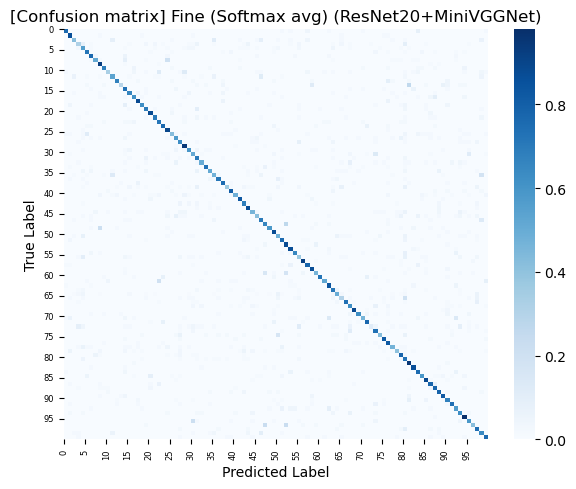

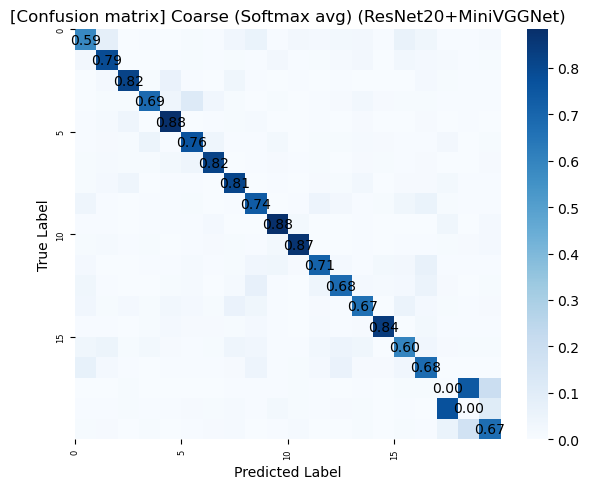

In [24]:
##confusion matrix fine class
plot_confusion_matrix_fine_sns(
    y_true=t_valid_fine,
    y_pred=ensemble_preds_fine_1,
    num_classes=100,
    title=f"[Confusion matrix] Fine (Softmax avg) ({'+'.join(selected_models)})",
    normalize=True
)


## confusion matrix coarse class
plot_confusion_matrix_sns(
    y_true=t_valid_coarse,
    y_pred=ensemble_preds_coarse_1,
    num_classes=20,
    title=f"[Confusion matrix] Coarse (Softmax avg) ({'+'.join(selected_models)})",
    normalize=True
)

### 2. weighted softmax

In [33]:
# 1. 모델 선택 + 가중치 설정
selected_models = ['ResNet20', 'MiniVGGNet', 'DenseNet22']
model_weights = [0.49,0.23,0.26]  

# 2. 선택된 모델들의 softmax 확률 weighted sum
ensemble_probs_2 = np.zeros_like(softmax_outputs[selected_models[0]])
for name, weight in zip(selected_models, model_weights):
    ensemble_probs_2 += softmax_outputs[name] * weight

ensemble_preds_fine_2 = np.argmax(ensemble_probs_2, axis=1)

# 3. Fine Accuracy
fine_acc = np.mean(ensemble_preds_fine_2 == t_valid_fine)
print(f"\n[Fine Label] Weighted Ensemble Accuracy ({'+'.join(selected_models)}): {fine_acc:.4f}")

# 4. Coarse Accuracy
ensemble_preds_coarse_2 = np.array([f2c[f] for f in ensemble_preds_fine_2])
coarse_acc_2 = np.mean(ensemble_preds_coarse_2 == t_valid_coarse)
print(f"[Coarse Label] Weighted Ensemble Accuracy: {coarse_acc_2:.4f}")


[Fine Label] Weighted Ensemble Accuracy (ResNet20+MiniVGGNet+DenseNet22): 0.6916
[Coarse Label] Weighted Ensemble Accuracy: 0.6934


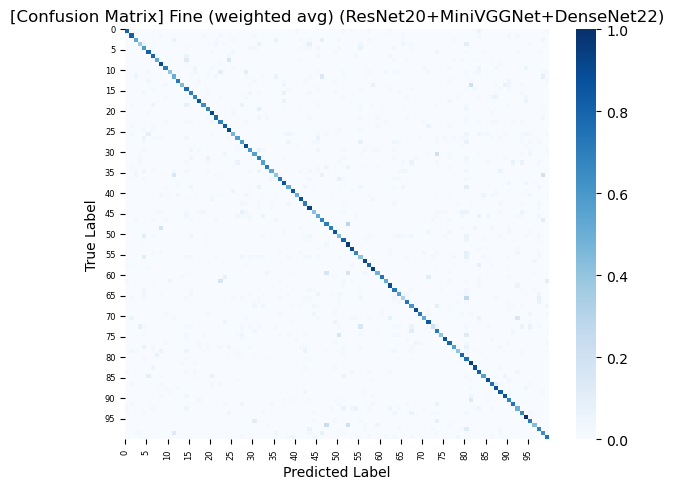

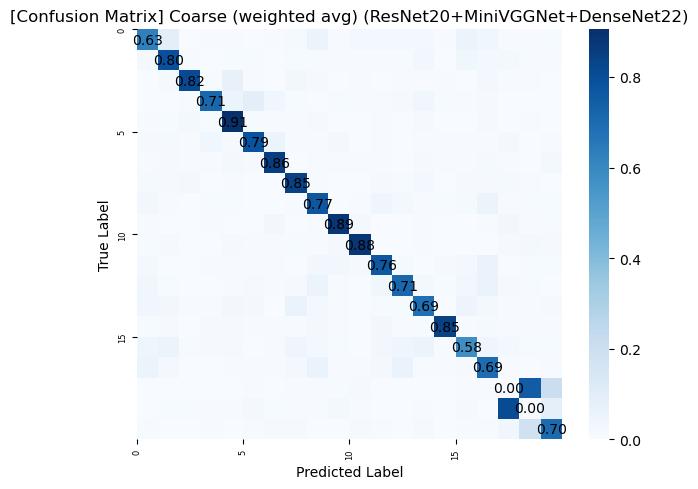

In [34]:
plot_confusion_matrix_fine_sns(
    y_true=t_valid_fine,
    y_pred=ensemble_preds_fine_2,
    num_classes=100,
    title=f"[Confusion Matrix] Fine (weighted avg) ({'+'.join(selected_models)})",
    normalize=True
)


plot_confusion_matrix_sns(
    y_true=t_valid_coarse,
    y_pred=ensemble_preds_coarse_2,
    num_classes=20,
    title=f"[Confusion Matrix] Coarse (weighted avg) ({'+'.join(selected_models)})",
    normalize=True
)

### 3. logit 후 softmax

In [35]:
import numpy as np
from common.functions import softmax
from common.coarse_mapping import get_cifar100_fine_to_coarse_dict

selected_models = ['ResNet20', 'MiniVGGNet', 'DenseNet22']

# 3. 평균 logit 계산 및 softmax
logits_list = [logit_outputs[name] for name in selected_models]
avg_logits = np.mean(logits_list, axis=0)              # shape: (N, 100)
ensemble_probs = softmax(avg_logits)                   # shape: (N, 100)
ensemble_preds_fine = np.argmax(ensemble_probs, axis=1)

# 4. Fine Accuracy
fine_acc = np.mean(ensemble_preds_fine == t_valid_fine)
print(f"\n[Fine Label] Ensemble Accuracy ({'+'.join(selected_models)}): {fine_acc:.4f}")

# 5. Coarse Accuracy
f2c = get_cifar100_fine_to_coarse_dict()
t_valid_coarse = np.array([f2c[f] for f in t_valid_fine])
ensemble_preds_coarse = np.array([f2c[f] for f in ensemble_preds_fine])
coarse_acc = np.mean(ensemble_preds_coarse == t_valid_coarse)
print(f"[Coarse Label] Ensemble Accuracy: {coarse_acc:.4f}")


[Fine Label] Ensemble Accuracy (ResNet20+MiniVGGNet+DenseNet22): 0.6806
[Coarse Label] Ensemble Accuracy: 0.7772


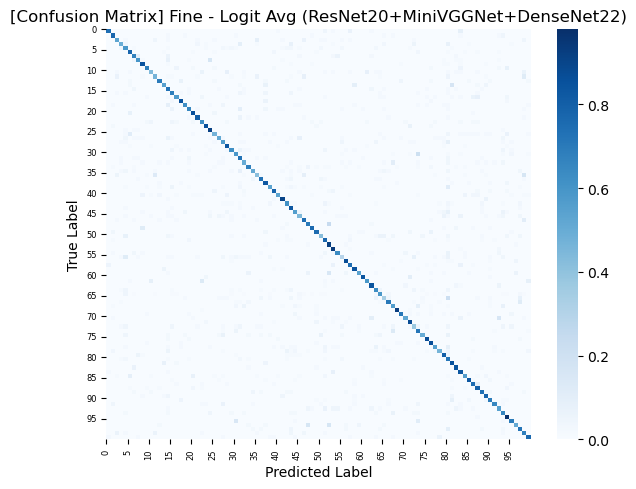

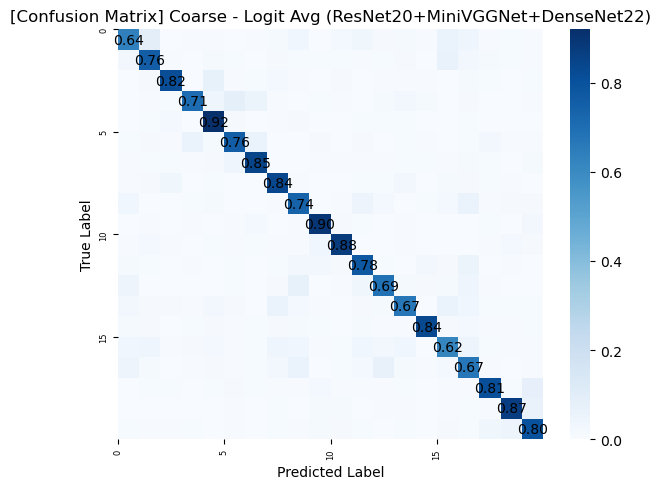

In [37]:
# Fine Label 기준 Confusion Matrix
plot_confusion_matrix_fine_sns(
    y_true=t_valid_fine,
    y_pred=ensemble_preds_fine,
    num_classes=100,
    title=f"[Confusion Matrix] Fine - Logit Avg ({'+'.join(selected_models)})",
    normalize=True
)

# Coarse Label 기준 Confusion Matrix
plot_confusion_matrix_sns(
    y_true=t_valid_coarse,
    y_pred=ensemble_preds_coarse,
    num_classes=20,
    title=f"[Confusion Matrix] Coarse - Logit Avg ({'+'.join(selected_models)})",
    normalize=True
)

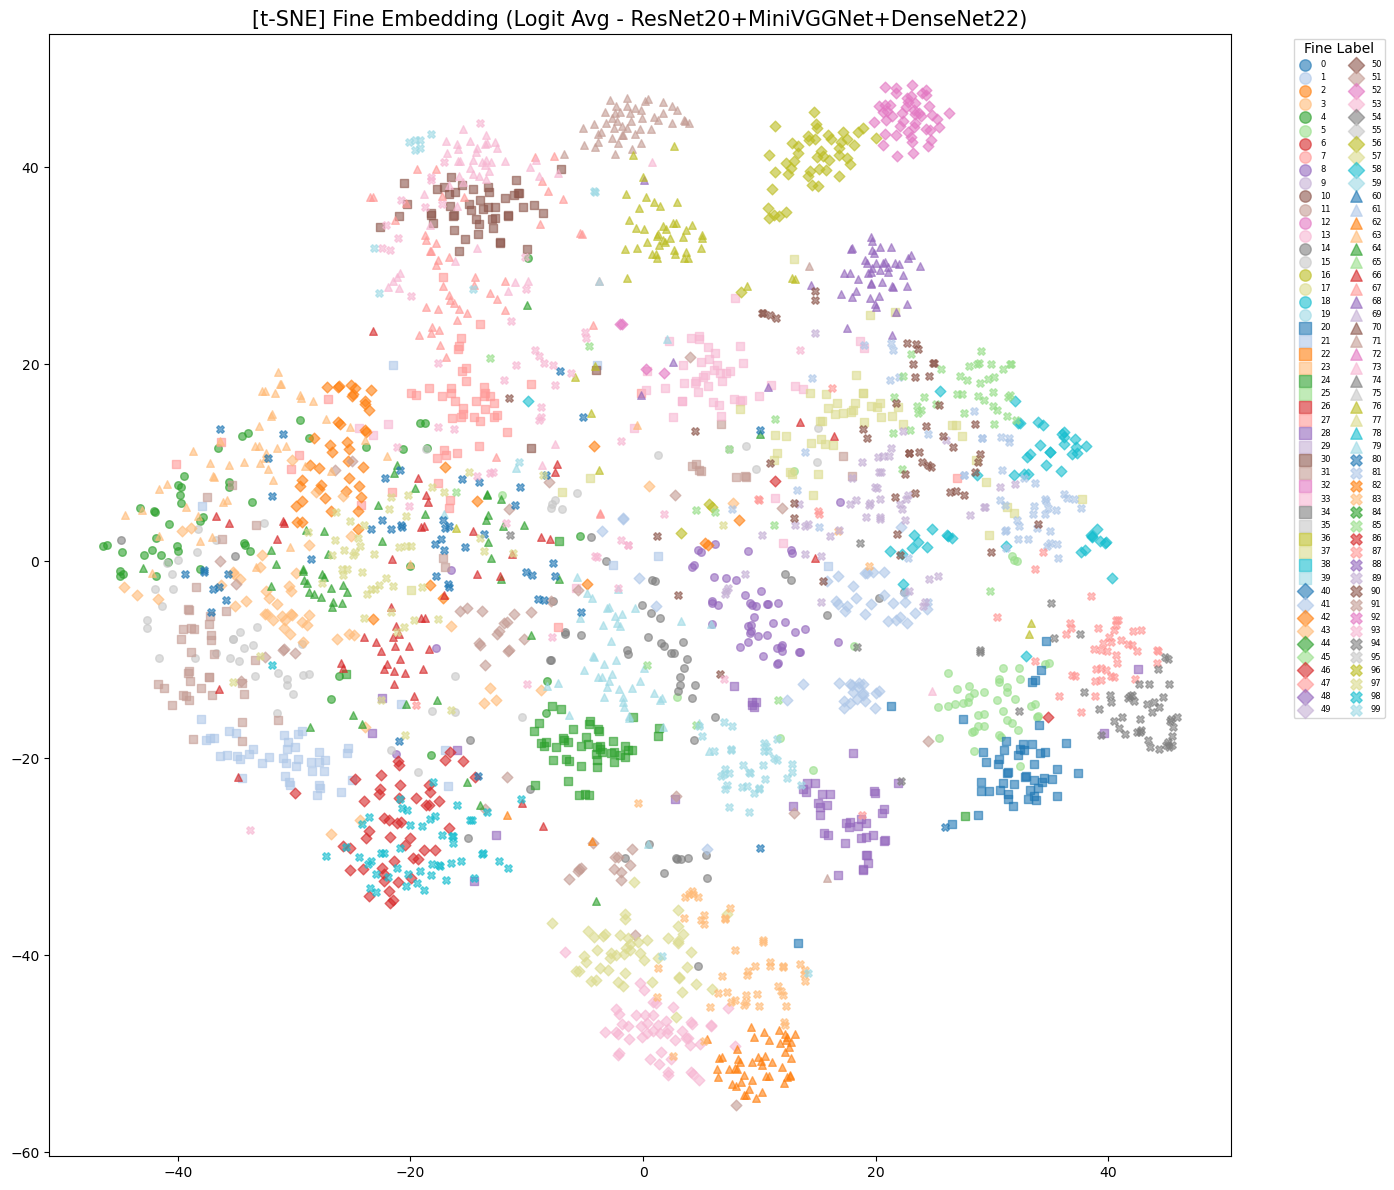

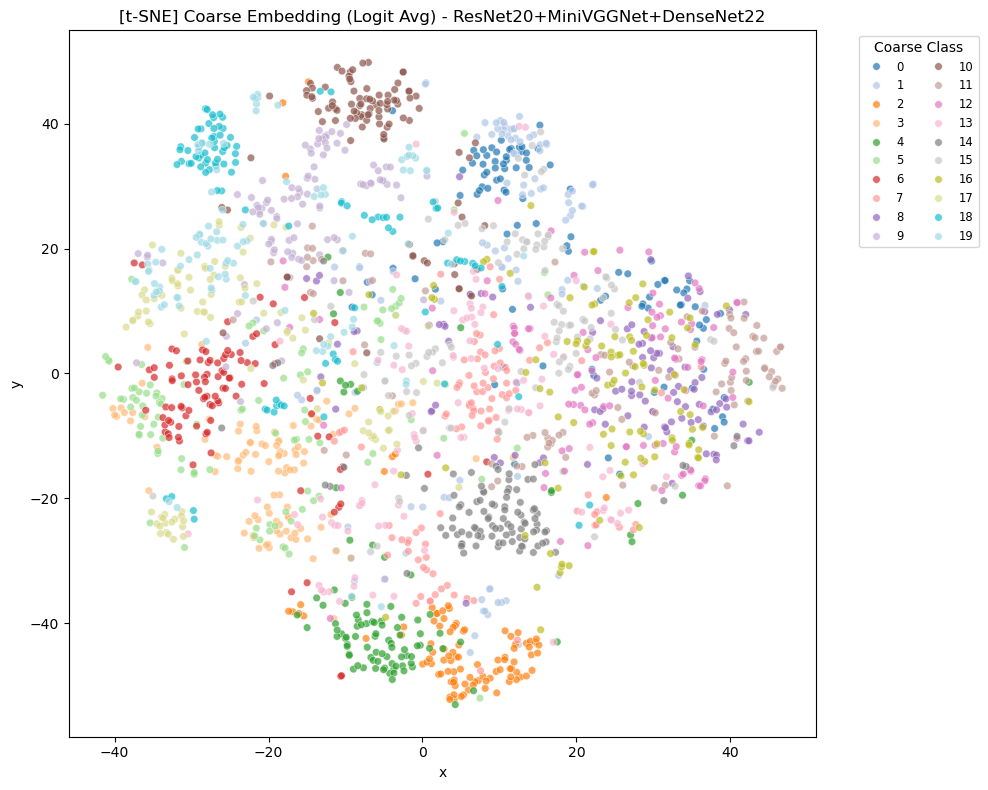

In [40]:
# Fine class용 balanced 샘플링
idx_fine = balanced_sample(ensemble_preds_fine, per_class=50, num_classes=100)

plot_tsne_fine(
    avg_logits[idx_fine],
    ensemble_preds_fine[idx_fine],
    title=f"[t-SNE] Fine Embedding (Logit Avg - {'+'.join(selected_models)})"
)

# Coarse class용 balanced 샘플링
idx_coarse = balanced_sample(ensemble_preds_coarse, per_class=100, num_classes=20)

plot_tsne_coarse(
    avg_logits[idx_coarse],
    ensemble_preds_coarse[idx_coarse],
    title="[t-SNE] Coarse Embedding (Logit Avg)",
    mapping_name=f"{'+'.join(selected_models)}"
)
